# Planet-moon injection and retrieval
Steps in this tutorial:
1. Create planet-moon model, use Kepler cadence
2. Add Gaussian noise to data
3. Use UltraNest + Pandora to fit planet-only model
4. Use UltraNest + Pandora to fit planet-with-moon model
5. Create cornerplots for both cases
6. Compare Bayesian evidence for both cases
7. Create light curve from maximum likelihood posteriors

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
import numpy as np

import pandoramoon as pandora
from pandoramoon.helpers import ld_convert, ld_invert

import ultranest
import ultranest.stepsampler
from ultranest import ReactiveNestedSampler
from ultranest.plot import cornerplot

## Create planet+moon model

Call Pandora and get model with these parameters

In [2]:
params = pandora.model_params()
R_sun = 696_342_000
params.R_star = R_sun  # [m]
params.u1 = 0.4089
params.u2 = 0.2556

Planet parameters:

In [3]:
params.per_bary = 365.25  # [days]
params.a_bary = 215  # [R_star]
params.r_planet = 0.1 # [R_star]
params.b_bary = 0.3   # [0..1]
params.t0_bary = 11  # [days]
params.t0_bary_offset = 0.01  # [days]
params.M_planet = 1.8986e+27  # [kg]
params.w_bary = 0  # [deg]
params.ecc_bary = 0.0  # [0..1]  

Moon parameters:

In [4]:
params.r_moon = 0.03526 # [R_star]
params.per_moon = 5 # [days]
params.tau_moon = 0.07  # [0..1]
params.Omega_moon = 0  # [0..180]
params.i_moon = 90  # [0..180]
params.e_moon = 0  # [0..1]
params.w_moon = 0  # [deg]
params.M_moon = 0.05395 * params.M_planet   # [0..1]

Other model parameters, e.g. 30 min Kepler cadence:

In [5]:
params.epochs = 3  # [int]
params.epoch_duration = 2  # [days]
params.cadences_per_day = 48  # [int]
params.epoch_distance = 365.26   # [days]
params.supersampling_factor = 1  # [int]
params.occult_small_threshold = 0.1  # [0..1]
params.hill_sphere_threshold = 1.2

Obtain time grid:

In [6]:
time = pandora.time(params).grid()

Define model:

In [7]:
model = pandora.moon_model(params)

Evaluate model for each point in time grid

In [8]:
injected_flux_total, injected_flux_planet, injected_flux_moon = model.light_curve(time)

## Create noise and merge with flux

In [9]:
noise_level = 500e-6  # Gaussian noise to be added to the generated data
np.random.seed(0)  # Reproducibility
noise = np.random.normal(0, noise_level, len(time))
testdata = noise + injected_flux_total
yerr = np.full(len(testdata), noise_level)

Plot synthetic data with and without noise:

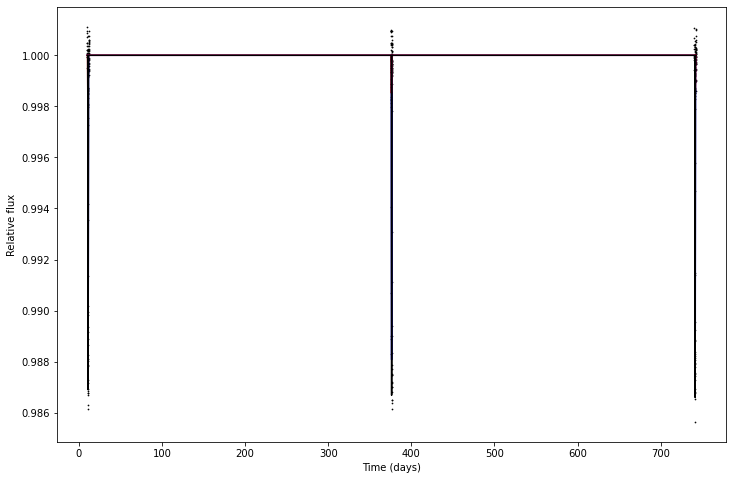

In [10]:
plt.plot(time, injected_flux_planet, color="blue")
plt.plot(time, injected_flux_moon, color="red")
plt.plot(time, injected_flux_total, color="black")
plt.scatter(time, testdata, color="black", s=0.5)
plt.xlabel("Time (days)")
plt.ylabel("Relative flux")
plt.show()

Let us have a look at the transits more closely:

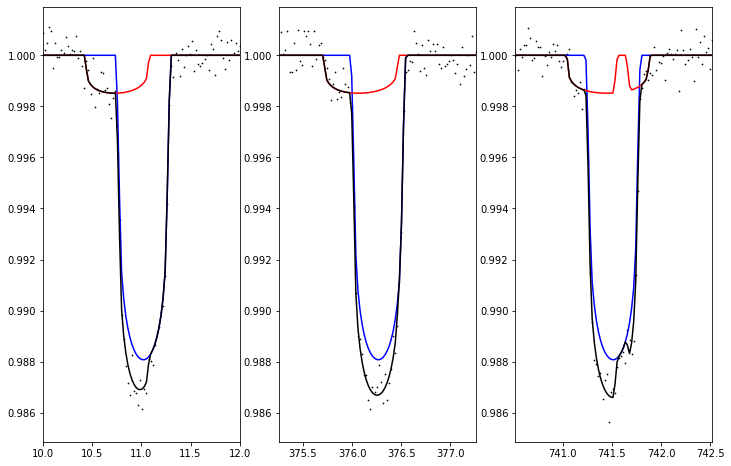

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(time, injected_flux_planet, color="blue")
ax1.plot(time, injected_flux_moon, color="red")
ax1.plot(time, injected_flux_total, color="black")
ax1.scatter(time, testdata, color="black", s=0.5)
ax1.set_xlim(min(time), min(time)+params.epoch_duration)

ax2.plot(time, injected_flux_planet, color="blue")
ax2.plot(time, injected_flux_moon, color="red")
ax2.plot(time, injected_flux_total, color="black")
ax2.scatter(time, testdata, color="black", s=0.5)
ax2.set_xlim(min(time)+params.epoch_distance, min(time)+params.epoch_duration+params.epoch_distance)

ax3.plot(time, injected_flux_planet, color="blue")
ax3.plot(time, injected_flux_moon, color="red")
ax3.plot(time, injected_flux_total, color="black")
ax3.scatter(time, testdata, color="black", s=0.5)
ax3.set_xlim(min(time)+2*params.epoch_distance, min(time)+params.epoch_duration+2*params.epoch_distance)

plt.show()

Interestingly, transit 3 of 3 has a planet-moon occultation!

## Retrieve planet-only model with UltraNest + Pandora

As a baseline, we fit a planet-only model to compare its Bayesian evidence with the planet+moon model.

UltraNest samples from a "unit-hypercube", which is an array of floats in [0,1]. We have to convert these to our physical units. We use fairly wide priors in this example. Priors need careful consideration in a real search effort, which is neglected here. 

It is important to make sure that the values `p` are physical: Pandora doesn't do many checks and will crash on unphysical values. That's a feature, not a bug: Pandora is designed to be fast. If you make it calculate a model with negative body radii, it will fail.

In [12]:
def prior_transform(cube):
    p    = cube.copy()
    p[0] = cube[0] * 10 + 360.25    # per_bary [days]
    p[1] = cube[1] * 300 + 1        # a_bary [R_star]
    p[2] = cube[2] * 0.2 + 0.001    # r_planet [R_star]
    p[3] = cube[3] * 1              # b_bary [0..1]
    p[4] = cube[4] * 0.1 - 0.05     # t0_bary_offset [days]
    p[5] = cube[5]                  # LD q1 [0..1]
    p[6] = cube[6]                  # LD q2 [0..1]
    return p

Next, we create a `log_likelihood` function. This is called by UltraNest to evaluate it model trial. It begins with converting limb darkening parameters of type `q` to quadratic `u` (see documentation and Kipping 2013).

In [13]:
def log_likelihood(p):
    # Convert q priors to u LDs (Kipping 2013)
    q1 = p[5]
    q2 = p[6]
    u1, u2 = ld_convert(q1, q2)

    # Calculate pandora model with trial parameters
    _, _, flux_trial_total, _, _, _, _ = pandora.pandora(
        R_star = R_sun,
        u1 = u1,
        u2 = u2,

        # Planet parameters
        per_bary = p[0],
        a_bary = p[1],
        r_planet = p[2],
        b_bary = p[3],
        w_bary = 0,
        ecc_bary = 0,
        t0_bary = params.t0_bary,
        t0_bary_offset = p[4],   
        M_planet = 1e27,

        # Moon parameters
        r_moon = 1e-8,  # negligible moon size
        per_moon = 30,  # other moon params do not matter
        tau_moon = 0,
        Omega_moon = 0,
        i_moon = 0,
        ecc_moon = 0,
        w_moon = 0,
        M_moon = 1e-8,  # negligible moon mass

        # Other model parameters
        epoch_distance = params.epoch_distance,
        supersampling_factor = 1,
        occult_small_threshold = 0.01,
        hill_sphere_threshold=1.0,
        numerical_grid=25,
        time=time,
        #cache=cache  # Can't use cache because free LDs
    )
    loglike = -0.5 * np.nansum(((flux_trial_total - testdata) / yerr)**2)

    return loglike

Note that we set very small moon radii and size, thus creating a model *with* a moon, but of negligible influence. Stellar radius, planetary mass, and moon period must be set as well, but are all irrelevant in the planet-only model.

Next, we define the names of the 7 free parameters of our planet-only model:

In [14]:
parameters = [
    'per_bary', 
    'a_bary', 
    'r_planet',
    'b_bary',
    't0_bary_offset',
    'q1',
    'q2'
    ]

For each, we set them all to *not* wrap around. Wrapping would be set to `true` if values `1=0`. In the planet+moon model, this is the case for the moon orbital phase `tau`.

In [15]:
wrapped_params = [
    False,
    False, 
    False, 
    False, 
    False, 
    False, 
    False
    ]

Now, we can define the UltraNest sampler. After much experimentation, the `RegionSliceSampler` is a good choice because it converges in ~99% of runs, and sampling is fast. Feel free to try out other samples and let the community know in case you find something faster!

As for the other parameters, we plan to go into more detail in future papers.

In [16]:
sampler = ReactiveNestedSampler(
            parameters,
            log_likelihood, 
            prior_transform,
            wrapped_params=wrapped_params,
            log_dir="results_injection_retrieval_planet_only"
            )
sampler.stepsampler = ultranest.stepsampler.RegionSliceSampler(
    nsteps=4000,
    adaptive_nsteps='move-distance',
    )  

Creating directory for new run results_injection_retrieval_planet_only/run1


That's it! We can now run UltraNest + Pandora:

In [17]:
result_planet_only = sampler.run(min_num_live_points=800)

[ultranest] Sampling 800 live points from prior ...


[ultranest] Explored until L=-3e+02  .84 [-290.4390..-290.4388]*| it/evals=25783/1564884 eff=1.6484% N=800   0    
[ultranest] Likelihood function evaluations: 1565235
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -317.9 +- 0.1214
[ultranest] Effective samples strategy satisfied (ESS = 5439.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.12 tail:0.01 total:0.12 required:<0.50
[ultranest] done iterating.


This runs on one core only, but should only take a few minutes. It prints a nice progress status while calculating.

Let's look at the results:

In [18]:
sampler.print_results()


logZ = -317.928 +- 0.266
  single instance: logZ = -317.928 +- 0.175
  bootstrapped   : logZ = -317.922 +- 0.265
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    per_bary            : 365.24311│ ▁ ▁▁▁▁▁▁▁▂▂▂▄▄▅▆▇▇▇▇▇▆▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁ │365.25132    365.24722 +- 0.00096
    a_bary              : 167.3 │ ▁▁▁▁▁▁▁▂▂▃▄▅▆▇▇▇▇▆▅▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁ │229.1     194.0 +- 7.8
    r_planet            : 0.1000│ ▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▄▄▅▅▆▅▇▇▇▇▆▅▄▂▂▁▁▁ ▁ │0.1137    0.1081 +- 0.0020
    b_bary              : 0.000 │▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▄▆▇▇▇▅▃▂▁▁▁ │0.703     0.519 +- 0.075
    t0_bary_offset      : 0.0092│ ▁ ▁▁▁▁▁▁▁▁▁▂▂▃▄▅▅▇▇▇▇▇▆▅▅▃▃▂▂▁▁▁▁▁▁▁▁ │0.0203    0.0151 +- 0.0013
    q1                  : 0.03  │ ▁▁▃▇▇▇▇▇▆▆▅▅▅▄▄▃▃▃▃▃▃▃▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁│1.00      0.37 +- 0.21
    q2                  : 0.00  │▅▅▇▇▇▇▇▆▆▆▇▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂│1.00      0.39 +- 0.26



And a cornerplot is readily available:

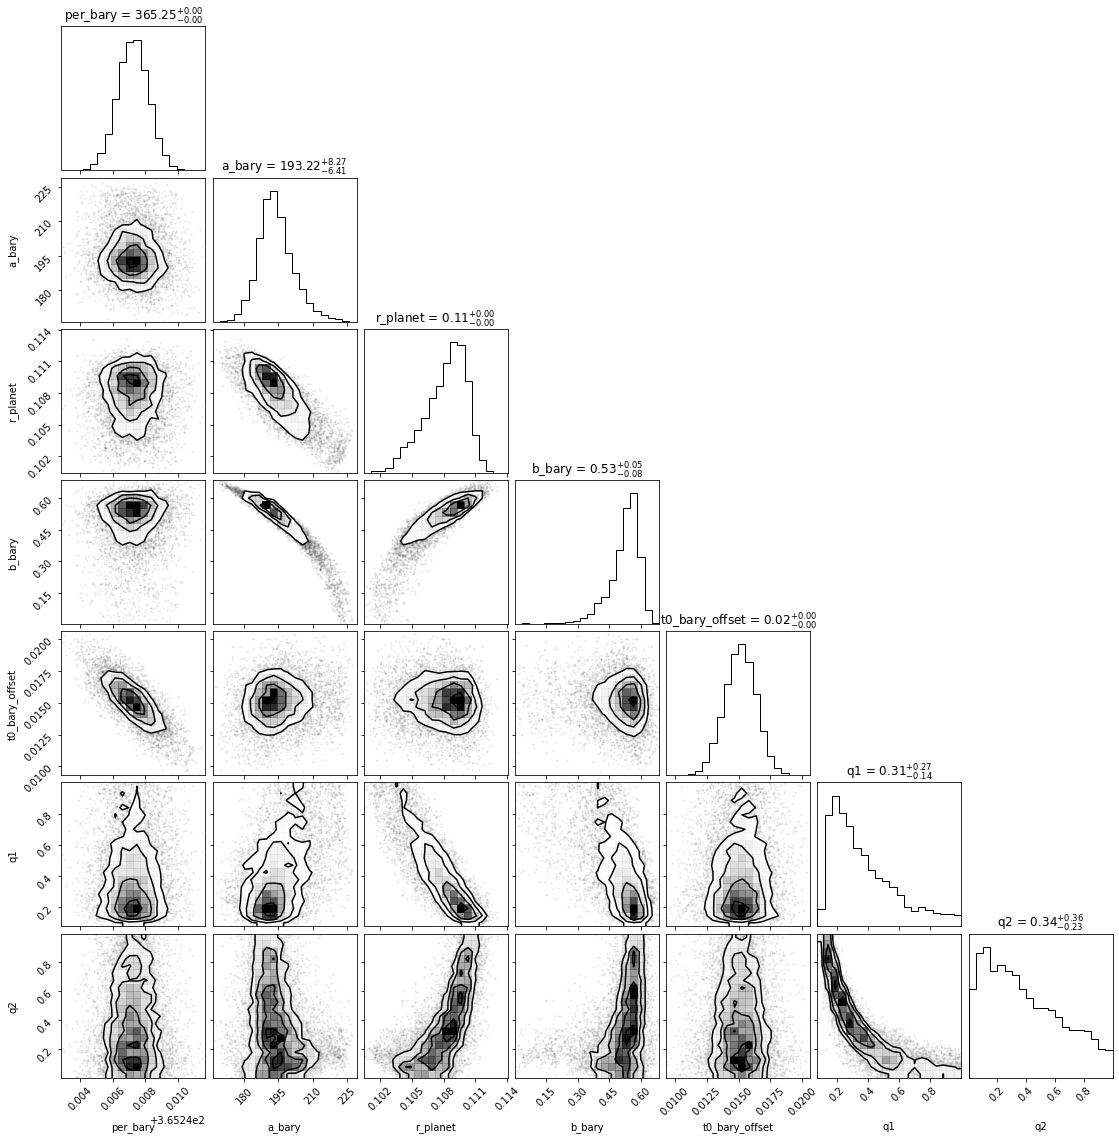

In [19]:
cornerplot(result_planet_only)
plt.show()

While the formating of labels is not perfect, we can see that some of the posteriors are a bit off compared to our injected values. That's a good sign - we fitted a planet-only model to data which contain planet + moon.

Instead of printing values from the UltraNest results directly, we will now use the results as saved in the JSON file to disk. This has the advantage to be able to pull results later again, without repeating the calculations.

In [20]:
import json
filename = "results_injection_retrieval_planet_only/run1/info/results.json"
with open(filename, 'r') as g:
    results_planet_only = json.load(g)
print("Planet-only logz:", results_planet_only["logz"])

Planet-only logz: -317.9283595602433


## Retrieve planet+moon model with UltraNest + Pandora

Now that we have calculated the planet-only baseline, we can finally get UltraNest running for the main course with planet+moon fit. We start by creating a new prior transformation, now with 15 free parameters (instead of 7 for the planet-only case):

In [21]:
def prior_transform(cube):
    p     = cube.copy()
    p[0]  = cube[0]  * 0.8 * R_sun + 0.4 * R_sun #  R_star [m]
    p[1]  = cube[1]  * 10 + 360.25    # per_bary [days]
    p[2]  = cube[2]  * 10 + 210       # a_bary [R_star]
    p[3]  = cube[3]  * 0.04 + 0.07    # r_planet [R_star]
    p[4]  = cube[4]  * 1              # b_bary [0..1]
    p[5]  = cube[5]  * 0.1 - 0.05     # t0_bary_offset [days]
    p[6]  = cube[6]  * 1e27 + 1.5e27  # M_planet [kg]
    p[7]  = cube[7]  * 0.06 + 0.01    # r_moon  [R_star]
    p[8]  = cube[8]  * 50             # per_moon  [days]
    p[9]  = cube[9]  * 1              # tau [0..1] 
    p[10] = cube[10] * 180            # Omega_moon [0..180]
    p[11] = cube[11] * 180            # i_moon [0..180]
    p[12] = cube[12] * 1e27 + 1       # M-moon [kg]
    p[13] = cube[13]                  # LD q1 [0..1]
    p[14] = cube[14]                  # LD q2 [0..1]
    return p

Our `log_likelihood` function is basically the same, but now contains all of these parameters:

In [22]:
def log_likelihood(p):
    # Convert q priors to u LDs (Kipping 2013)
    q1 = p[13]
    q2 = p[14]
    u1, u2 = ld_convert(q1, q2)

    # Calculate pandora model with trial parameters
    _, _, flux_trial_total, _, _, _, _ = pandora.pandora(
        R_star = p[0],
        u1 = u1,
        u2 = u2,

        # Planet parameters
        per_bary = p[1],
        a_bary = p[2],
        r_planet = p[3],
        b_bary = p[4],
        w_bary = 0,
        ecc_bary = 0,
        t0_bary = params.t0_bary,
        t0_bary_offset = p[5],   
        M_planet = p[6],

        # Moon parameters
        r_moon = p[7],
        per_moon = p[8],
        tau_moon = p[9],
        Omega_moon = p[10],
        i_moon = p[11],
        ecc_moon = 0,
        w_moon = 0,
        M_moon = p[12],

        # Other model parameters
        epoch_distance = params.epoch_distance,
        supersampling_factor = 1,
        occult_small_threshold = 0.01,
        hill_sphere_threshold=1.0,
        numerical_grid=25,
        time=time,
        #cache=cache  # Can't use cache because free LDs
    )
    loglike = -0.5 * np.nansum(((flux_trial_total - testdata) / yerr)**2)

    return loglike

We want to have the correct variable names in the JSON result file, and in the cornerplot:

In [23]:
parameters = [
    'R_star', 
    'per_bary', 
    'a_bary', 
    'r_planet',
    'b_bary',
    't0_bary_offset',
    'M_planet',
    'r_moon',
    'per_moon',
    'tau',
    'Omega_moon',
    'i_moon',
    'M_moon',
    'q1',
    'q2'
    ]

Now, the `tau` parameter wraps around, because the moon's orbital position in `[0,1]` is identical for `0`and `1`. The same would be correct to define if sampling `Omega_moon` and `i_moon` in `[0,360]`. You can choose to do so, but it is unnecessary: Both halfs of `[0,180]` are indistinguishable as long as the moon's light-travel-time (Roemer effect) is below the noise threshold.

In [24]:
wrapped_params = [
    False,
    False, 
    False, 
    False, 
    False, 
    False, 
    False, 
    False, 
    False,
    True,  # tau 
    False,
    False,  
    False,
    False,
    False
    ]

We use the same sampler settings are before: 

In [25]:
sampler = ReactiveNestedSampler(
            parameters,
            log_likelihood, 
            prior_transform,
            wrapped_params=wrapped_params,
            log_dir="results_injection_retrieval_planet_moon"
            )

sampler.stepsampler = ultranest.stepsampler.RegionSliceSampler(
    nsteps=4000,
    adaptive_nsteps='move-distance',
    )

Creating directory for new run results_injection_retrieval_planet_moon/run1


And now we can sample the planet+moon model with UltraNest. This takes 5-6 hours on a single core of a year 2021 AMD Ryzen 5950X processor, performing ~300 million model evaluations (using `min_num_live_points=800`). Larger values explore the landscape more deeply, but take longer.

In [26]:
result_planet_moon = sampler.run(min_num_live_points=2000)

[ultranest] Sampling 2000 live points from prior ...


[ultranest] Explored until L=-1e+02  .17 [-140.9831..-140.9831]*| it/evals=81055/693690438 eff=0.0116% N=1640     
[ultranest] Likelihood function evaluations: 693690438
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -185.5 +- 0.1253
[ultranest] Effective samples strategy satisfied (ESS = 13644.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.


Let's look at the posteriors:

In [27]:
sampler.print_results()


logZ = -185.443 +- 0.267
  single instance: logZ = -185.443 +- 0.143
  bootstrapped   : logZ = -185.454 +- 0.267
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    R_star              : 520285927│ ▁▁▁▁▁   ▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▆▇▂▂▃▇▄▁▁▁▁▁▁▁ │835609843    727829986 +- 35383114
    per_bary            : 365.2418│ ▁▁▁▁▁▁▁▁▁▁▁▂▃▃▂▁▁▁▂▄▇▇▇▆▅▅▃▁▁▁▁▁▁▁▁▁▁ │365.2653    365.2546 +- 0.0030
    a_bary              : 210.00│▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▇▆▅▂▂▂▂▁▁  ▁▁ ▁▁▁▁▁│220.00    215.49 +- 0.86
    r_planet            : 0.0948│ ▁▁▁▁▁▁▁▁▁▁▅▇▅▄▃▅▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁ │0.1046    0.0989 +- 0.0015
    b_bary              : 0.000 │▁▁▁▁▁▃▇▄▆▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁ │0.451     0.135 +- 0.093
    t0_bary_offset      : -0.0266│ ▁▁▁▁     ▁▂▅▃▂▄▇▇▄▁▁▁▁▂▁▁▃▂▁▁▁▁▁▁▁▁▁▁ │0.0264    -0.0018 +- 0.0070
    M_planet            : 1500000999999999857282514944│▁▁▁▁▁▁▁▁▁▁▃▃▇▇▅▅▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁ │2467632583220052862770872320    1885774484760403678689492992 +- 1598625200

And the cornerplot:

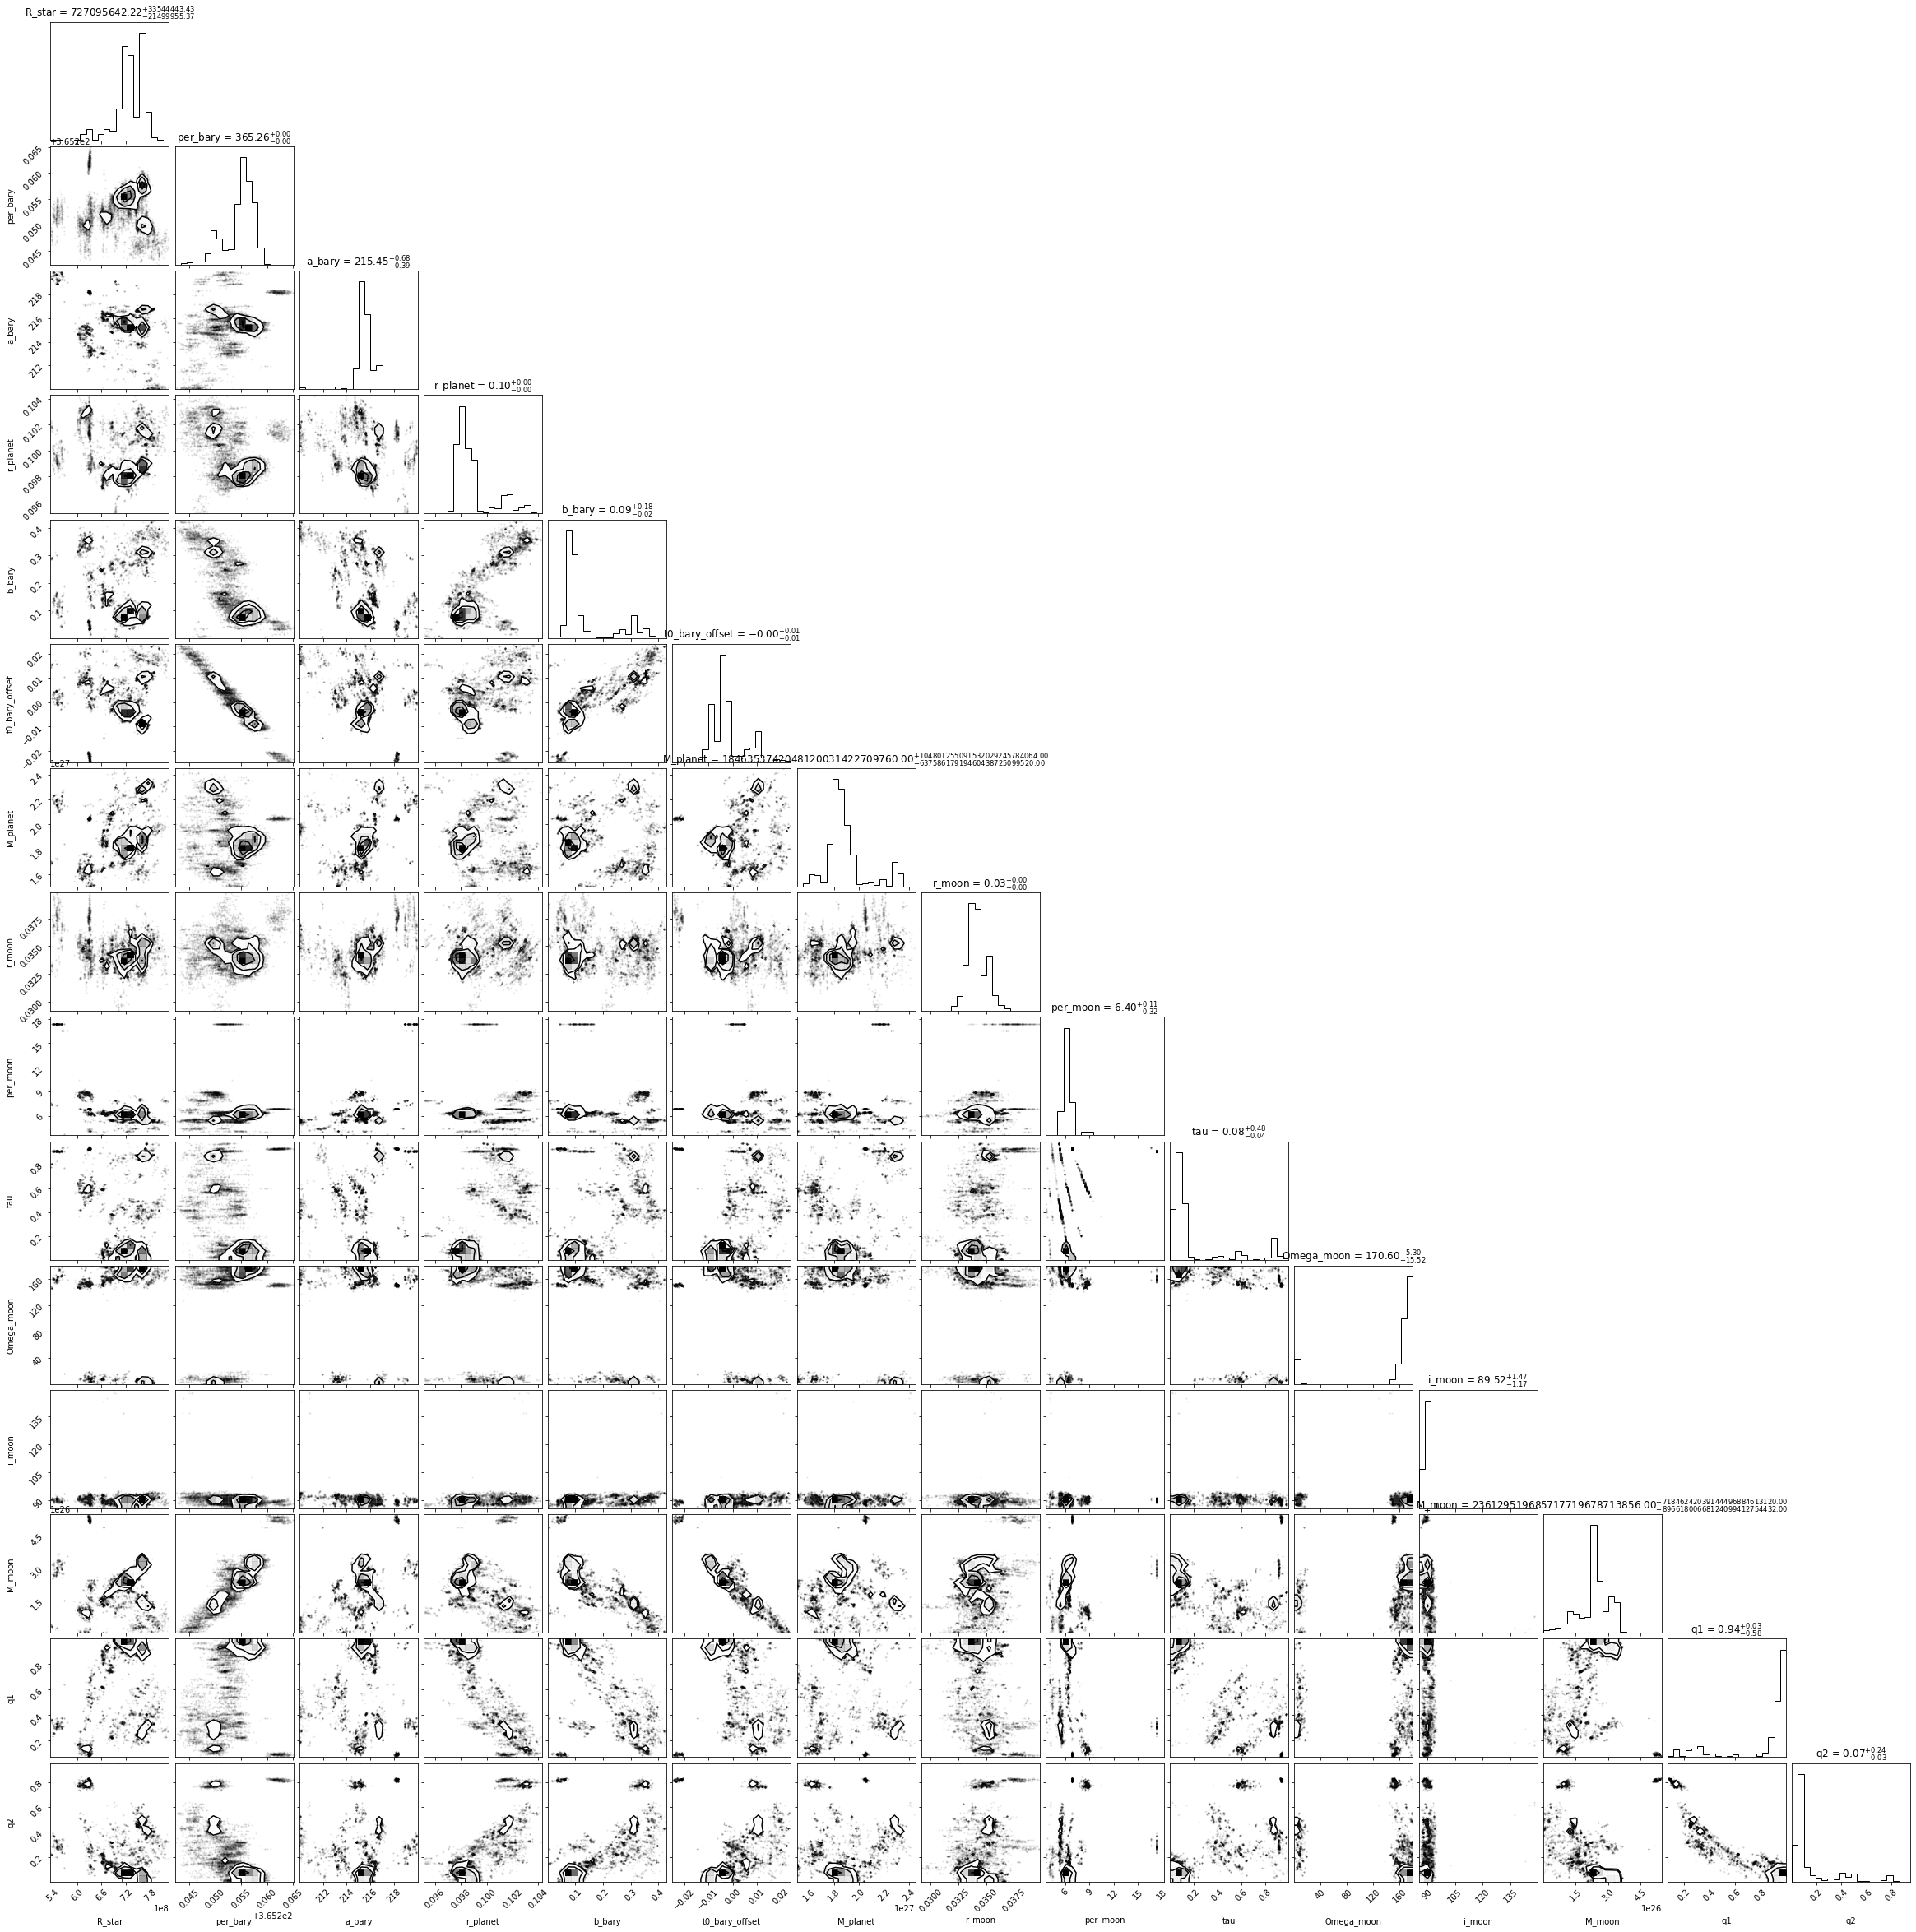

In [28]:
cornerplot(result_planet_moon)

Let us get the `logz`value from the JSON which we saved to disk:

In [29]:
import json
filename = "results_injection_retrieval_planet_moon/run1/info/results.json"
with open(filename, 'r') as g:
    results_planet_moon = json.load(g)
print("Planet+moon logz:", results_planet_moon["logz"])

Planet+moon logz: -185.44284237872802


Let's calculate the Bayesian evidence in favor of the planet+moon model:

In [30]:
print("Bayes difference", results_planet_moon["logz"] - results_planet_only["logz"])

Bayes difference 132.48551718151526


This large difference between the `logz` values indicates decisive evidence for the planet+moon model.

## Create light curve from maximum likelihood posteriors

As a last step, we wish to visually confirm that the planet+moon model discovered through sampling is a much better fit than the planet-only model. Again, we get the results from the JSON file as saved to disk. We use the maximum likelihood model.

In [31]:
print(results_planet_only["paramnames"])

['per_bary', 'a_bary', 'r_planet', 'b_bary', 't0_bary_offset', 'q1', 'q2']


In [32]:
mll_planet_only_per_bary = results_planet_only["maximum_likelihood"]["point"][0]
mll_planet_only_a_bary = results_planet_only["maximum_likelihood"]["point"][1]
mll_planet_only_r_planet = results_planet_only["maximum_likelihood"]["point"][2]
mll_planet_only_b_bary = results_planet_only["maximum_likelihood"]["point"][3]
mll_planet_only_t0_bary_offset = results_planet_only["maximum_likelihood"]["point"][4]
mll_planet_only_q1 = results_planet_only["maximum_likelihood"]["point"][5]
mll_planet_only_q2 = results_planet_only["maximum_likelihood"]["point"][6]

print("Maximum likelihoods for planet-only fit:")
print("per_bary", mll_planet_only_per_bary)
print("a_bary", mll_planet_only_a_bary)
print("r_planet", mll_planet_only_r_planet)
print("b_bary", mll_planet_only_b_bary)
print("t0_bary_offset", mll_planet_only_t0_bary_offset)
print("q1", mll_planet_only_q1)
print("q2", mll_planet_only_q2)

Maximum likelihoods for planet-only fit:
per_bary 365.2471558918627
a_bary 191.37383988019675
r_planet 0.11007986296512509
b_bary 0.5610209075562181
t0_bary_offset 0.0151354127454921
q1 0.1646755475068483
q2 0.7714145878905475


OK, that was a bit tedious and explicit, but the values look reasonable. Let's create another Pandora model with these values.

In [33]:
params = pandora.model_params()
R_sun = 696_342_000
params.R_star = R_sun  # [m]

# Convert limb darkening back from q to u type:
u1, u2 = ld_invert(mll_planet_only_q1, mll_planet_only_q2)
params.u1 = u1
params.u2 = u2

# Planet parameters
params.per_bary = mll_planet_only_per_bary  # [days]
params.a_bary = mll_planet_only_a_bary  # [R_star]
params.r_planet = mll_planet_only_r_planet # [R_star]
params.b_bary = mll_planet_only_b_bary   # [0..1]
params.t0_bary = 11  # [days]
params.t0_bary_offset = mll_planet_only_t0_bary_offset  # [days]
params.M_planet = 1e27  # [kg]
params.w_bary = 0  # [deg]
params.ecc_bary = 0.0  # [0..1]  

# Moon parameters
params.r_moon = 1e-8  # negligible moon size
params.per_moon = 30  # other moon params do not matter
params.tau_moon = 0
params.Omega_moon = 0
params.i_moon = 0
params.ecc_moon = 0
params.w_moon = 0
params.M_moon = 1e-8  # negligible moon mass

# Other model parameters
params.epochs = 3  # [int]
params.epoch_duration = 2  # [days]
params.cadences_per_day = 48  # [int]
params.epoch_distance = 365.26   # [days]
params.supersampling_factor = 1  # [int]
params.occult_small_threshold = 0.1  # [0..1]
params.hill_sphere_threshold = 1.2

# Obtain time grid
time = pandora.time(params).grid()

# Define model
model = pandora.moon_model(params)

# Evaluate model for each point in time grid
po_flux_total, po_flux_planet, po_flux_moon = model.light_curve(time)

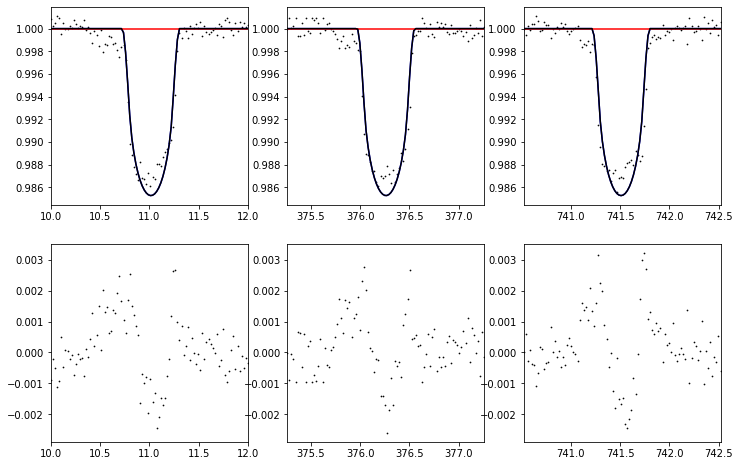

In [34]:
fig, axs = plt.subplots(2, 3)
axs[0,0].plot(time, po_flux_planet, color="blue")
axs[0,0].plot(time, po_flux_moon, color="red")
axs[0,0].plot(time, po_flux_total, color="black")
axs[0,0].scatter(time, testdata, color="black", s=0.5)
axs[0,0].set_xlim(min(time), min(time)+params.epoch_duration)
axs[1,0].scatter(time, po_flux_total-testdata, color="black", s=0.5)
axs[1,0].set_xlim(min(time), min(time)+params.epoch_duration)

axs[0,1].plot(time, po_flux_planet, color="blue")
axs[0,1].plot(time, po_flux_moon, color="red")
axs[0,1].plot(time, po_flux_total, color="black")
axs[0,1].scatter(time, testdata, color="black", s=0.5)
axs[0,1].set_xlim(min(time)+params.epoch_distance, min(time)+params.epoch_duration+params.epoch_distance)
axs[1,1].scatter(time, po_flux_total-testdata, color="black", s=0.5)
axs[1,1].set_xlim(min(time)+params.epoch_distance, min(time)+params.epoch_duration+params.epoch_distance)

axs[0,2].plot(time, po_flux_planet, color="blue")
axs[0,2].plot(time, po_flux_moon, color="red")
axs[0,2].plot(time, po_flux_total, color="black")
axs[0,2].scatter(time, testdata, color="black", s=0.5)
axs[0,2].set_xlim(min(time)+2*params.epoch_distance, min(time)+params.epoch_duration+2*params.epoch_distance)
axs[1,2].scatter(time, po_flux_total-testdata, color="black", s=0.5)
axs[1,2].set_xlim(min(time)+2*params.epoch_distance, min(time)+params.epoch_duration+2*params.epoch_distance)

plt.show()

We can see that the fit is not great - there are lots of residuals, which shouldn't be there because we have created pure Gaussian noise, no instrumental trends. Perhaps that's related to our moon signal? Let's find out!

### Maximum likelihood model for the planet+moon case

In [35]:
print(results_planet_moon["paramnames"])

['R_star', 'per_bary', 'a_bary', 'r_planet', 'b_bary', 't0_bary_offset', 'M_planet', 'r_moon', 'per_moon', 'tau', 'Omega_moon', 'i_moon', 'M_moon', 'q1', 'q2']


In [36]:
mll_planet_moon_R_star = results_planet_moon["maximum_likelihood"]["point"][0]
mll_planet_moon_per_bary = results_planet_moon["maximum_likelihood"]["point"][1]
mll_planet_moon_a_bary = results_planet_moon["maximum_likelihood"]["point"][2]
mll_planet_moon_r_planet = results_planet_moon["maximum_likelihood"]["point"][3]
mll_planet_moon_b_bary = results_planet_moon["maximum_likelihood"]["point"][4]
mll_planet_moon_t0_bary_offset = results_planet_moon["maximum_likelihood"]["point"][5]
mll_planet_moon_M_planet = results_planet_moon["maximum_likelihood"]["point"][6]
mll_planet_moon_r_moon = results_planet_moon["maximum_likelihood"]["point"][7]
mll_planet_moon_per_moon = results_planet_moon["maximum_likelihood"]["point"][8]
mll_planet_moon_tau = results_planet_moon["maximum_likelihood"]["point"][9]
mll_planet_moon_Omega_moon = results_planet_moon["maximum_likelihood"]["point"][10]
mll_planet_moon_i_moon = results_planet_moon["maximum_likelihood"]["point"][11]
mll_planet_moon_M_moon = results_planet_moon["maximum_likelihood"]["point"][12]
mll_planet_moon_q1 = results_planet_moon["maximum_likelihood"]["point"][13]
mll_planet_moon_q2 = results_planet_moon["maximum_likelihood"]["point"][14]

print("Maximum likelihoods for planet-only fit:")
print("R_star", mll_planet_moon_R_star)
print("per_bary", mll_planet_moon_per_bary)
print("a_bary", mll_planet_moon_a_bary)
print("r_planet", mll_planet_moon_r_planet)
print("b_bary", mll_planet_moon_b_bary)
print("t0_bary_offset", mll_planet_moon_t0_bary_offset)
print("M_planet", mll_planet_moon_M_planet)
print("r_moon", mll_planet_moon_r_moon)
print("per_moon", mll_planet_moon_per_moon)
print("tau", mll_planet_moon_tau)
print("Omega_moon", mll_planet_moon_Omega_moon)
print("i_moon", mll_planet_moon_i_moon)
print("M_moon", mll_planet_moon_M_moon)
print("q1", mll_planet_moon_q1)
print("q2", mll_planet_moon_q2)

Maximum likelihoods for planet-only fit:
R_star 747123139.5950826
per_bary 365.249896156998
a_bary 216.75469779908818
r_planet 0.10166757894429808
b_bary 0.31104099404209445
t0_bary_offset 0.009834779127180018
M_planet 2.2693691751802807e+27
r_moon 0.035495606015880275
per_moon 5.447832638865585
tau 0.8791850049340569
Omega_moon 6.125429669554411
i_moon 89.77597518230867
M_moon 1.4085380958972437e+26
q1 0.24546715448910125
q2 0.43904305056632403


Again, that was a bit tedious and explicit, but the values look reasonable. Let's create another Pandora model with these values.

In [37]:
params = pandora.model_params()
params.R_star = mll_planet_moon_R_star  # [m]

# Convert limb darkening back from q to u type:
u1, u2 = ld_invert(mll_planet_moon_q1, mll_planet_moon_q2)
params.u1 = u1
params.u2 = u2

# Planet parameters
params.per_bary = mll_planet_moon_per_bary  # [days]
params.a_bary = mll_planet_moon_a_bary  # [R_star]
params.r_planet = mll_planet_moon_r_planet # [R_star]
params.b_bary = mll_planet_moon_b_bary   # [0..1]
params.t0_bary = 11  # [days]
params.t0_bary_offset = mll_planet_moon_t0_bary_offset  # [days]
params.M_planet = mll_planet_moon_M_planet  # [kg]
params.w_bary = 0  # [deg]
params.ecc_bary = 0.0  # [0..1]  

# Moon parameters
params.r_moon = mll_planet_moon_r_moon
params.per_moon = mll_planet_moon_per_moon
params.tau_moon = mll_planet_moon_tau
params.Omega_moon = mll_planet_moon_Omega_moon
params.i_moon = mll_planet_moon_i_moon
params.ecc_moon = 0
params.w_moon = 0
params.M_moon = mll_planet_moon_M_moon

# Other model parameters
params.epochs = 3  # [int]
params.epoch_duration = 2  # [days]
params.cadences_per_day = 48  # [int]
params.epoch_distance = 365.26   # [days]
params.supersampling_factor = 1  # [int]
params.occult_small_threshold = 0.1  # [0..1]
params.hill_sphere_threshold = 1.2

# Obtain time grid
time = pandora.time(params).grid()

# Define model
model = pandora.moon_model(params)

# Evaluate model for each point in time grid
pm_flux_total, pm_flux_planet, pm_flux_moon = model.light_curve(time)

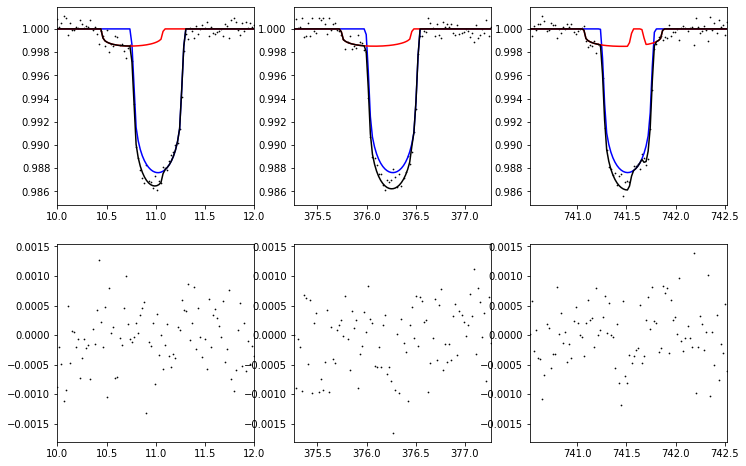

In [38]:
fig, axs = plt.subplots(2, 3)
axs[0,0].plot(time, pm_flux_planet, color="blue")
axs[0,0].plot(time, pm_flux_moon, color="red")
axs[0,0].plot(time, pm_flux_total, color="black")
axs[0,0].scatter(time, testdata, color="black", s=0.5)
axs[0,0].set_xlim(min(time), min(time)+params.epoch_duration)
axs[1,0].scatter(time, pm_flux_total-testdata, color="black", s=0.5)
axs[1,0].set_xlim(min(time), min(time)+params.epoch_duration)

axs[0,1].plot(time, pm_flux_planet, color="blue")
axs[0,1].plot(time, pm_flux_moon, color="red")
axs[0,1].plot(time, pm_flux_total, color="black")
axs[0,1].scatter(time, testdata, color="black", s=0.5)
axs[0,1].set_xlim(min(time)+params.epoch_distance, min(time)+params.epoch_duration+params.epoch_distance)
axs[1,1].scatter(time, pm_flux_total-testdata, color="black", s=0.5)
axs[1,1].set_xlim(min(time)+params.epoch_distance, min(time)+params.epoch_duration+params.epoch_distance)

axs[0,2].plot(time, pm_flux_planet, color="blue")
axs[0,2].plot(time, pm_flux_moon, color="red")
axs[0,2].plot(time, pm_flux_total, color="black")
axs[0,2].scatter(time, testdata, color="black", s=0.5)
axs[0,2].set_xlim(min(time)+2*params.epoch_distance, min(time)+params.epoch_duration+2*params.epoch_distance)
axs[1,2].scatter(time, pm_flux_total-testdata, color="black", s=0.5)
axs[1,2].set_xlim(min(time)+2*params.epoch_distance, min(time)+params.epoch_duration+2*params.epoch_distance)

plt.show()

Hey, that looks very similar (although not identical) to the injected model. In other words - successful first recovery! This is the end of the first tutorial. Future tutorials will cover other samplers yielding better results, and further exploration of the post-detection validation methods.